In [ ]:
"""
Dataset verification script for COCO JSON + Images folder.

Paths (change if needed):
- coco_json = "/content/drive/MyDrive/Dataset_endometrium/_annotations.coco.json"
- images_dir = "/content/drive/MyDrive/Dataset_endometrium/Images"

Outputs (in images_dir/../verification_report/):
- summary.txt
- images_summary.csv
- annotations_summary.csv
- missing_images.csv
- images_no_annotations.csv
- category_counts.csv

Requirements:
- pip install pycocotools (optional, used to compute mask areas if segmentation present)
- standard: numpy, pandas, pillow
"""

import os
import json
from glob import glob
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

# Optionally use pycocotools if installed to compute mask areas reliably
try:
    from pycocotools import mask as maskUtils
    PYCOCO = True
except Exception:
    PYCOCO = False

# === USER PARAMETERS ===
coco_json = "/content/drive/MyDrive/Dataset_endometrium/_annotations.coco.json"
images_dir = "/content/drive/MyDrive/Dataset_endometrium/Images"
out_dir = os.path.join(os.path.dirname(coco_json), "verification_report")
os.makedirs(out_dir, exist_ok=True)

# === Helpers ===
def load_coco(path):
    with open(path, "r") as f:
        data = json.load(f)
    return data

def write_txt(path, lines):
    with open(path, "w") as f:
        f.write("\n".join(lines))

# === Load ===
print("Loading COCO JSON:", coco_json)
coco = load_coco(coco_json)

# Build lookup dicts
images = coco.get("images", [])
anns = coco.get("annotations", [])
cats = coco.get("categories", [])

img_by_id = {img["id"]: img for img in images}
img_filename_to_id = {img["file_name"]: img["id"] for img in images}

# list files on disk
disk_images = []
for ext in ("*.jpg","*.jpeg","*.png","*.tif","*.tiff","*.bmp"):
    disk_images.extend(glob(os.path.join(images_dir, ext)))
disk_images = [os.path.basename(p) for p in disk_images]

# === Basic counts ===
num_json_images = len(images)
num_disk_images = len(disk_images)
num_annotations = len(anns)
num_categories = len(cats)

summary_lines = []
summary_lines.append(f"JSON images: {num_json_images}")
summary_lines.append(f"Disk images: {num_disk_images}")
summary_lines.append(f"Annotations: {num_annotations}")
summary_lines.append(f"Categories: {num_categories}")

# === Missing / extra images ===
disk_set = set(disk_images)
json_set = set(img_filename_to_id.keys())

images_on_disk_not_in_json = sorted(list(disk_set - json_set))
images_in_json_missing_on_disk = sorted(list(json_set - disk_set))

summary_lines.append(f"Images on disk but not in JSON: {len(images_on_disk_not_in_json)}")
summary_lines.append(f"Images in JSON but missing on disk: {len(images_in_json_missing_on_disk)}")

# === Annotations per image ===
anns_per_image = defaultdict(list)
for a in anns:
    img_id = a.get("image_id")
    anns_per_image[img_id].append(a)

anns_count_per_image = {img_id: len(anns_per_image.get(img_id, [])) for img_id in img_by_id.keys()}
zero_ann_images = [img_by_id[i]["file_name"] for i,cnt in anns_count_per_image.items() if cnt==0]

summary_lines.append(f"Images with zero annotations (in JSON): {len(zero_ann_images)}")

# === Annotations referencing missing images ===
ann_missing_image = [a for a in anns if a.get("image_id") not in img_by_id]
summary_lines.append(f"Annotations referencing missing image ids: {len(ann_missing_image)}")

# === Category counts ===
cat_id_to_name = {c["id"]: c.get("name", str(c["id"])) for c in cats}
cat_counts = Counter()
for a in anns:
    cat_counts[a["category_id"]] += 1
cat_counts_named = {cat_id_to_name[int(k)]: int(v) for k,v in cat_counts.items()}
summary_lines.append("Top categories (count):")
for k,v in sorted(cat_counts_named.items(), key=lambda x:-x[1])[:20]:
    summary_lines.append(f"  {k}: {v}")

# === BBox stats (if bbox present) ===
bboxes = [a["bbox"] for a in anns if "bbox" in a and a["bbox"] is not None]
if bboxes:
    bboxes = np.array(bboxes)  # [x,y,w,h]
    widths = bboxes[:,2]
    heights = bboxes[:,3]
    summary_lines.append(f"BBox width px: min {widths.min():.1f}, mean {widths.mean():.1f}, max {widths.max():.1f}")
    summary_lines.append(f"BBox height px: min {heights.min():.1f}, mean {heights.mean():.1f}, max {heights.max():.1f}")
else:
    summary_lines.append("No bbox data found in annotations.")

# === Segmentation presence & area ===
seg_with_poly = 0
seg_with_rle = 0
areas_from_ann = []
areas_from_mask = []
segmentation_present = False

for a in anns:
    seg = a.get("segmentation", None)
    if seg:
        segmentation_present = True
        # polygon (list) or RLE (dict)
        if isinstance(seg, list):
            seg_with_poly += 1
            # area field sometimes present
            if "area" in a:
                areas_from_ann.append(a["area"])
        elif isinstance(seg, dict):
            seg_with_rle += 1
            if "area" in a:
                areas_from_ann.append(a["area"])

summary_lines.append(f"Annotations with polygon segmentation: {seg_with_poly}")
summary_lines.append(f"Annotations with RLE segmentation: {seg_with_rle}")
summary_lines.append(f"Annotations with 'area' field: {len(areas_from_ann)}")

# If pycocotools is available, compute mask area for a sample to cross-check
if PYCOCO and segmentation_present:
    try:
        # compute area for first 50 annotations with segmentation
        computed = []
        for a in anns[:min(200, len(anns))]:
            seg = a.get("segmentation", None)
            if not seg:
                continue
            if isinstance(seg, list):
                rles = maskUtils.frPyObjects(seg, img_by_id[a["image_id"]]["height"], img_by_id[a["image_id"]]["width"])
                rle = maskUtils.merge(rles)
                area = float(maskUtils.area(rle))
                computed.append(area)
            elif isinstance(seg, dict):
                area = float(maskUtils.area(seg))
                computed.append(area)
        if computed:
            summary_lines.append(f"Example recomputed mask area -- min {np.min(computed):.1f}, mean {np.mean(computed):.1f}, max {np.max(computed):.1f}")
    except Exception as e:
        summary_lines.append(f"pycocotools area compute failed: {str(e)}")
else:
    summary_lines.append("pycocotools not available or no segmentation present; skipping recomputed mask area checks.")

# === Image size distribution & duplicates ===
widths = []
heights = []
file_name_counts = Counter([img["file_name"] for img in images])
duplicate_filenames = [fn for fn,ct in file_name_counts.items() if ct>1]
duplicate_image_ids = [img_id for img_id in img_by_id.keys() if list(img_by_id.keys()).count(img_id) > 1]  # rare

for img in images:
    w = img.get("width", None)
    h = img.get("height", None)
    if w: widths.append(w)
    if h: heights.append(h)

if widths:
    summary_lines.append(f"Image widths: min {min(widths)}, mean {np.mean(widths):.1f}, max {max(widths)}")
if heights:
    summary_lines.append(f"Image heights: min {min(heights)}, mean {np.mean(heights):.1f}, max {max(heights)}")
summary_lines.append(f"Duplicate filenames in JSON: {len(duplicate_filenames)}")

# === Save CSVs ===
# images_summary.csv
images_rows = []
for img in images:
    iid = img["id"]
    fn = img["file_name"]
    path_on_disk = os.path.join(images_dir, fn)
    exists = os.path.exists(path_on_disk)
    images_rows.append({
        "image_id": iid,
        "file_name": fn,
        "width": img.get("width", None),
        "height": img.get("height", None),
        "on_disk": exists,
        "num_annotations": anns_count_per_image.get(iid, 0)
    })
df_images = pd.DataFrame(images_rows)
df_images.to_csv(os.path.join(out_dir, "images_summary.csv"), index=False)

# annotations_summary.csv
anns_rows = []
for a in anns:
    anns_rows.append({
        "annotation_id": a.get("id"),
        "image_id": a.get("image_id"),
        "category_id": a.get("category_id"),
        "bbox_x": a.get("bbox", [None, None, None, None])[0] if a.get("bbox") else None,
        "bbox_y": a.get("bbox", [None, None, None, None])[1] if a.get("bbox") else None,
        "bbox_w": a.get("bbox", [None, None, None, None])[2] if a.get("bbox") else None,
        "bbox_h": a.get("bbox", [None, None, None, None])[3] if a.get("bbox") else None,
        "has_segmentation": 1 if a.get("segmentation") else 0,
        "area_field": a.get("area", None)
    })
df_anns = pd.DataFrame(anns_rows)
df_anns.to_csv(os.path.join(out_dir, "annotations_summary.csv"), index=False)

# missing images
pd.DataFrame({"missing_images_in_json": images_in_json_missing_on_disk}).to_csv(os.path.join(out_dir, "missing_images.csv"), index=False)
pd.DataFrame({"images_on_disk_not_in_json": images_on_disk_not_in_json}).to_csv(os.path.join(out_dir, "images_not_in_json.csv"), index=False)

# images with zero annotations
pd.DataFrame({"images_with_zero_annotations": zero_ann_images}).to_csv(os.path.join(out_dir, "images_no_annotations.csv"), index=False)

# category counts
df_cat = pd.DataFrame([{"category_id": int(k), "category_name": cat_id_to_name[int(k)], "count": int(v)} for k,v in cat_counts.items()])
df_cat = df_cat.sort_values("count", ascending=False)
df_cat.to_csv(os.path.join(out_dir, "category_counts.csv"), index=False)

# write summary txt
summary_path = os.path.join(out_dir, "summary.txt")
write_txt(summary_path, summary_lines)

# Print top-level summary
print("\n".join(summary_lines))
print("\nSaved report files to:", out_dir)


Loading COCO JSON: /content/drive/MyDrive/Dataset_endometrium/_annotations.coco.json
JSON images: 503
Disk images: 510
Annotations: 503
Categories: 2
Images on disk but not in JSON: 7
Images in JSON but missing on disk: 0
Images with zero annotations (in JSON): 0
Annotations referencing missing image ids: 0
Top categories (count):
  0: 503
BBox width px: min 14.0, mean 129.0, max 296.0
BBox height px: min 16.0, mean 106.8, max 321.0
Annotations with polygon segmentation: 503
Annotations with RLE segmentation: 0
Annotations with 'area' field: 503
Example recomputed mask area -- min 533.0, mean 4944.8, max 19754.0
Image widths: min 512, mean 512.0, max 512
Image heights: min 512, mean 512.0, max 512
Duplicate filenames in JSON: 0

Saved report files to: /content/drive/MyDrive/Dataset_endometrium/verification_report


In [ ]:
import os
from glob import glob
json_fnames = set([img["file_name"] for img in coco["images"]])
disk_files = [os.path.basename(p) for p in glob(os.path.join(images_dir, "*.*"))]
extras = sorted([f for f in disk_files if f not in json_fnames])
print("Extra files:", extras)


Extra files: ['08604040-1_png.rf.0d025894a9e6c18318334b3086e68677 (1).jpg', '08940140-4_png.rf.8df077aa7426c390e7dbe31d36f21c7b (1).jpg', '09079410_png.rf.a7cc5a203b8ff30f5822c04d74d374be (1).jpg', '09215810_png.rf.d800722af532f4bf9629d1355b0fae6c (1).jpg', '09292000-1_png.rf.28aa996d648803d7769f3a3998ba3787 (1).jpg', '09391890-10_png.rf.4eb66a252b7504293733e53d785c5cd3 (1).jpg', '09391890-11_png.rf.600452c1c55b8ce72e93c24b26dd8dff (1).jpg']


In [ ]:
# OPTION A: percentile-based automatic labeling (COLAB)
import os, json, math
import numpy as np, pandas as pd
from glob import glob
from skimage import draw
from scipy import ndimage as ndi

coco_json = "/content/drive/MyDrive/Dataset_endometrium/_annotations.coco.json"
images_dir = "/content/drive/MyDrive/Dataset_endometrium/Images"
out_dir = os.path.join(os.path.dirname(coco_json), "verification_report")
os.makedirs(out_dir, exist_ok=True)

with open(coco_json,'r') as f:
    coco = json.load(f)
images = {img['id']: img for img in coco.get('images', [])}
anns = coco.get('annotations', [])

# optional pycocotools
try:
    from pycocotools import mask as maskUtils
    PYCOCO = True
except:
    PYCOCO = False

records=[]
for a in anns:
    img_meta = images[a['image_id']]
    h,w = img_meta.get('height',512), img_meta.get('width',512)
    mask = np.zeros((h,w), dtype=np.uint8)
    seg = a.get('segmentation')
    if seg:
        if PYCOCO:
            if isinstance(seg, list):
                rles = maskUtils.frPyObjects(seg, h, w)
                rle = maskUtils.merge(rles)
                m = maskUtils.decode(rle)
                mask = (m>0).astype(np.uint8)
            elif isinstance(seg, dict):
                m = maskUtils.decode(seg); mask=(m>0).astype(np.uint8)
        else:
            if isinstance(seg, list):
                for poly in seg:
                    poly = np.array(poly).reshape(-1,2)
                    rr,cc = draw.polygon(poly[:,1], poly[:,0], mask.shape)
                    mask[rr,cc]=1
    area = int(mask.sum())
    if area>0:
        dist = ndi.distance_transform_edt(mask)
        max_th = float(dist.max())*2.0
    else:
        max_th = 0.0
    records.append({'image_id': a['image_id'], 'file_name': img_meta['file_name'],
                    'area_px':area, 'max_thickness_px':max_th})

df = pd.DataFrame(records)
vals = df['max_thickness_px'].replace(0,np.nan).dropna()
p33 = np.percentile(vals,33) if len(vals)>0 else 0
p67 = np.percentile(vals,67) if len(vals)>0 else 0

def label_by_px(th):
    if math.isnan(th) or th==0: return "uncertain",1,"no_mask"
    if th>=p67: return "receptive",5,f"th_px>={p67:.1f}"
    if th< p33: return "non-receptive",3,f"th_px<{p33:.1f}"
    return "uncertain",1,f"{p33:.1f}<=th<{p67:.1f}"

labels = [label_by_px(x) for x in df['max_thickness_px']]
df[['label','label_confidence','label_reason']] = pd.DataFrame(labels, index=df.index)
out_csv = os.path.join(out_dir, "labels_master_percentile.csv")
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)
print("Counts:\n", df['label'].value_counts())

Saved: /content/drive/MyDrive/Dataset_endometrium/verification_report/labels_master_percentile.csv
Counts:
 label
uncertain        171
non-receptive    166
receptive        166
Name: count, dtype: int64


In [ ]:
import os, json, numpy as np, pandas as pd
from glob import glob
from scipy import ndimage as ndi
from skimage import draw, io, color, measure
from pycocotools import mask as maskUtils

# Paths
coco_json = "/content/drive/MyDrive/Dataset_endometrium/_annotations.coco.json"
images_dir = "/content/drive/MyDrive/Dataset_endometrium/Images"
out_dir = "/content/drive/MyDrive/Dataset_endometrium/verification_report"
os.makedirs(out_dir, exist_ok=True)

# Load COCO
with open(coco_json, "r") as f:
    coco = json.load(f)
images = {img["id"]: img for img in coco["images"]}
anns = coco["annotations"]

records = []
for a in anns:
    img_meta = images[a["image_id"]]
    fn = img_meta["file_name"]
    h, w = img_meta.get("height", 512), img_meta.get("width", 512)

    # Build mask
    seg = a.get("segmentation")
    mask = np.zeros((h,w), dtype=np.uint8)
    if isinstance(seg, list):
        rles = maskUtils.frPyObjects(seg, h, w)
        rle = maskUtils.merge(rles)
        mask = maskUtils.decode(rle)
    elif isinstance(seg, dict):
        mask = maskUtils.decode(seg)
    mask = mask.astype(np.uint8)

    # Compute features
    area = mask.sum()
    dist = ndi.distance_transform_edt(mask)
    max_th = 2 * dist.max()
    mean_intensity = io.imread(os.path.join(images_dir, fn))
    if mean_intensity.ndim == 3:
        mean_intensity = color.rgb2gray(mean_intensity)
    mean_val = mean_intensity[mask>0].mean() if area>0 else 0

    props = measure.regionprops(mask.astype(int))
    perim = props[0].perimeter if props else 0
    bbox = props[0].bbox if props else (0,0,0,0)
    bbox_h = bbox[2]-bbox[0]
    bbox_w = bbox[3]-bbox[1]
    density = area / (bbox_h*bbox_w + 1e-6)
    aspect_ratio = bbox_w / (bbox_h + 1e-6)
    compactness = (4*np.pi*area)/(perim**2 + 1e-6) if perim>0 else 0

    records.append({
        "image_id": a["image_id"],
        "file_name": fn,
        "area_px": area,
        "max_thickness_px": max_th,
        "mean_intensity": mean_val,
        "bbox_width_px": bbox_w,
        "bbox_height_px": bbox_h,
        "density": density,
        "aspect_ratio": aspect_ratio,
        "compactness": compactness
    })

df = pd.DataFrame(records)
df.to_csv(os.path.join(out_dir, "image_features_full.csv"), index=False)
print("Extracted features for", len(df), "images.")

Extracted features for 503 images.


Feature importances:
max_thickness_px: 1.000
area_px: 0.000
mean_intensity: 0.000
density: 0.000
aspect_ratio: 0.000
compactness: 0.000

Training set accuracy:
               precision    recall  f1-score   support

Non-Receptive       1.00      1.00      1.00       166
    Receptive       1.00      1.00      1.00       166

     accuracy                           1.00       332
    macro avg       1.00      1.00      1.00       332
 weighted avg       1.00      1.00      1.00       332



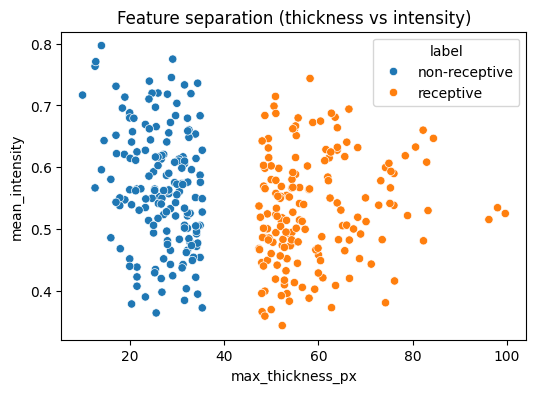

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load both datasets
features = pd.read_csv("/content/drive/MyDrive/Dataset_endometrium/verification_report/image_features_full.csv")
labels = pd.read_csv("/content/drive/MyDrive/Dataset_endometrium/verification_report/labels_master_percentile.csv")

# Merge on file name
merged = pd.merge(features, labels[["file_name","label"]], on="file_name", how="left")

# Use only confident samples (ignore uncertain) to learn rules
train_df = merged[merged["label"].isin(["receptive","non-receptive"])].copy()

# Prepare features & labels
X = train_df[["max_thickness_px","area_px","mean_intensity","density","aspect_ratio","compactness"]]
y = (train_df["label"]=="receptive").astype(int)

# Train simple decision tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X, y)

print("Feature importances:")
for name, imp in zip(X.columns, tree.feature_importances_):
    print(f"{name}: {imp:.3f}")

# Evaluate
y_pred = tree.predict(X)
print("\nTraining set accuracy:")
print(classification_report(y, y_pred, target_names=["Non-Receptive","Receptive"]))

# Visualize feature separation
plt.figure(figsize=(6,4))
sns.scatterplot(data=train_df, x="max_thickness_px", y="mean_intensity", hue="label")
plt.title("Feature separation (thickness vs intensity)")
plt.show()

In [ ]:
# Apply model to all samples
X_all = merged[["max_thickness_px","area_px","mean_intensity","density","aspect_ratio","compactness"]]
merged["pred_label"] = tree.predict(X_all)
merged["pred_label"] = merged["pred_label"].map({1:"receptive",0:"non-receptive"})

# Save relabeled dataset
out_csv = "/content/drive/MyDrive/Dataset_endometrium/verification_report/labels_final_verified.csv"
merged.to_csv(out_csv, index=False)
print("Saved final verified labels to:", out_csv)

print(merged["pred_label"].value_counts())

Saved final verified labels to: /content/drive/MyDrive/Dataset_endometrium/verification_report/labels_final_verified.csv
pred_label
non-receptive    253
receptive        250
Name: count, dtype: int64


In [ ]:
converted = merged[merged["label"]=="uncertain"].sample(5, random_state=42)
print(converted[["file_name","pred_label","max_thickness_px","mean_intensity"]])

                                             file_name     pred_label  \
302  30320840_1_png.rf.e776886990ab6ef22bb6c2197ccf...      receptive   
165  00963550-2_png.rf.e676c7aa278d77830510605a188a...  non-receptive   
167  30276400-3_png.rf.536420d4aa7be8250457bcd95738...  non-receptive   
418  10007950-3_png.rf.37b9a70f7d34c9ed72d1e2b720a2...      receptive   
457  12752720-1_png.rf.0c042290fe6bd12ffcac208d48b4...      receptive   

     max_thickness_px  mean_intensity  
302         42.520583        0.399584  
165         37.576588        0.521284  
167         38.209946        0.663486  
418         42.047592        0.464059  
457         42.755117        0.491104  


In [ ]:
import pandas as pd
import numpy as np

# Paths
features_path = "/content/drive/MyDrive/Dataset_endometrium/verification_report/image_features_full.csv"
labels_path   = "/content/drive/MyDrive/Dataset_endometrium/verification_report/labels_final_verified.csv"

# Load both
df_features = pd.read_csv(features_path)
df_labels   = pd.read_csv(labels_path)[["file_name", "pred_label"]]

# Merge to single master DataFrame
df = pd.merge(df_features, df_labels, on="file_name", how="left")

print("✅ Merged dataset shape:", df.shape)
print("Label distribution:\n", df["pred_label"].value_counts())
df.head()

✅ Merged dataset shape: (503, 11)
Label distribution:
 pred_label
non-receptive    253
receptive        250
Name: count, dtype: int64


,image_id,file_name,area_px,max_thickness_px,mean_intensity,bbox_width_px,bbox_height_px,density,aspect_ratio,compactness,pred_label
0,0,07535820-2_png.rf.a8ae0c0302d0238c2525af0a72cb...,1296,23.323808,0.389827,88,50,0.294545,1.760000,0.355499,non-receptive
1,1,13158420-2_png.rf.18c75547c1bdf8ea9a7599691ad4...,4103,46.043458,0.566114,102,111,0.362392,0.918919,0.478866,receptive
2,2,10747000-1_png.rf.6132ad6cd6b0bebbe6664e5252c4...,7367,64.000000,0.627539,150,106,0.463333,1.415094,0.512629,receptive
3,3,05083470-10_png.rf.bee93fb17d9753193f65e77fbf5...,3743,36.221541,0.520716,136,67,0.410777,2.029851,0.361145,non-receptive
4,4,12752720-5_png.rf.2051a44b6938fd9c246e3df6215b...,2343,26.305893,0.551957,116,41,0.492641,2.829268,0.387290,non-receptive


In [ ]:
# Missing values
print("Missing values per column:")
print(df.isna().sum())

# Basic stats
print("\nBasic feature stats:")
print(df.describe().T)

# Check for zero areas or thickness
print("\nZero area or thickness count:")
print(len(df[(df["area_px"] == 0) | (df["max_thickness_px"] == 0)]))


Missing values per column:
image_id            0
file_name           0
area_px             0
max_thickness_px    0
mean_intensity      0
bbox_width_px       0
bbox_height_px      0
density             0
aspect_ratio        0
compactness         0
pred_label          0
dtype: int64

Basic feature stats:
                  count         mean          std         min          25%  \
image_id          503.0   251.000000   145.347859    0.000000   125.500000   
area_px           503.0  4706.399602  2929.832543  411.000000  2558.500000   
max_thickness_px  503.0    42.344172    15.030544   10.000000    32.000000   
mean_intensity    503.0     0.544997     0.093402    0.327758     0.478275   
bbox_width_px     503.0   128.642147    53.208857   14.000000    88.000000   
bbox_height_px    503.0   105.890656    61.915104   16.000000    58.000000   
density           503.0     0.419149     0.192725    0.092483     0.240658   
aspect_ratio      503.0     1.450042     0.685999    0.176471     0.9815

In [ ]:
df = df[(df["area_px"] > 0) & (df["max_thickness_px"] > 0)].reset_index(drop=True)

In [ ]:
df["label"] = df["pred_label"].map({"non-receptive": 0, "receptive": 1})
df.drop(columns=["pred_label"], inplace=True)
print(df["label"].value_counts())

label
0    253
1    250
Name: count, dtype: int64


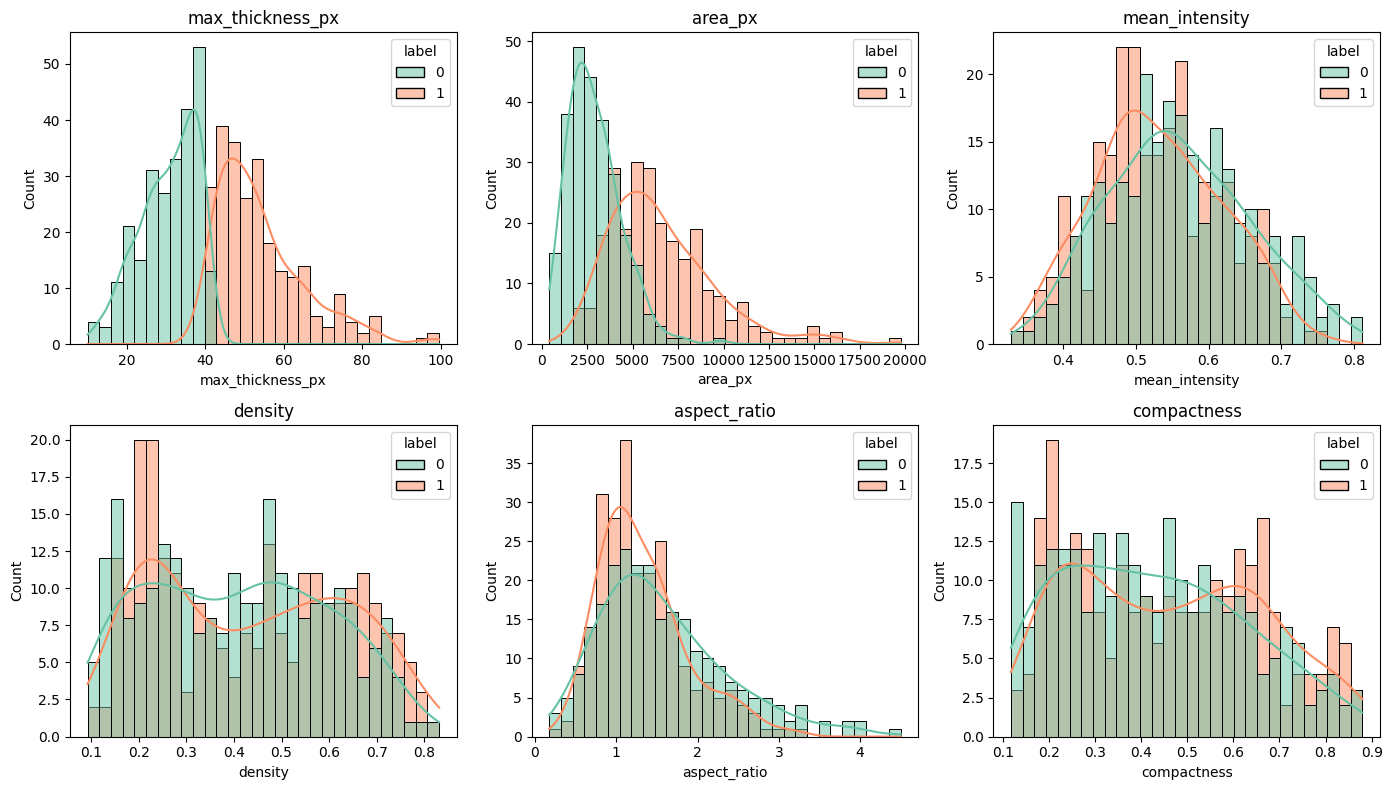

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

num_features = ["max_thickness_px", "area_px", "mean_intensity", "density", "aspect_ratio", "compactness"]

plt.figure(figsize=(14,8))
for i, col in enumerate(num_features, 1):
    plt.subplot(2,3,i)
    sns.histplot(data=df, x=col, hue="label", kde=True, palette="Set2", bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

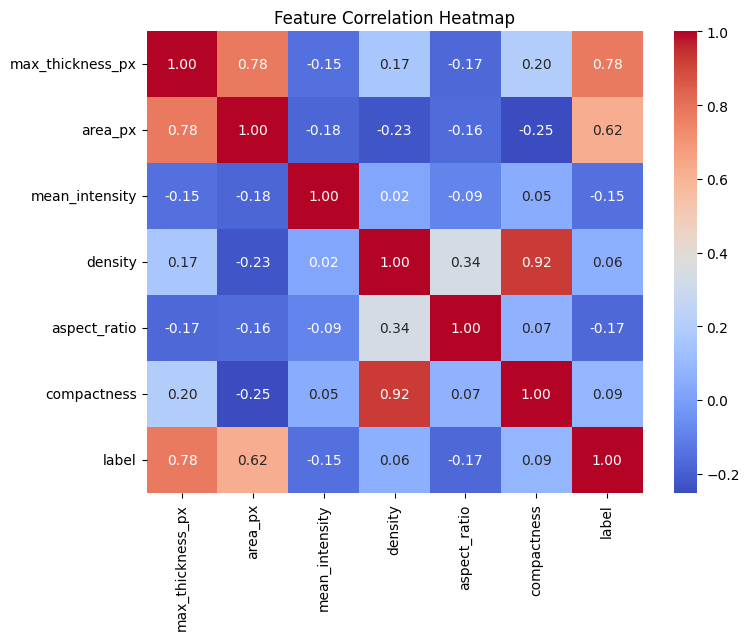

In [ ]:
plt.figure(figsize=(8,6))
corr = df[num_features + ["label"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

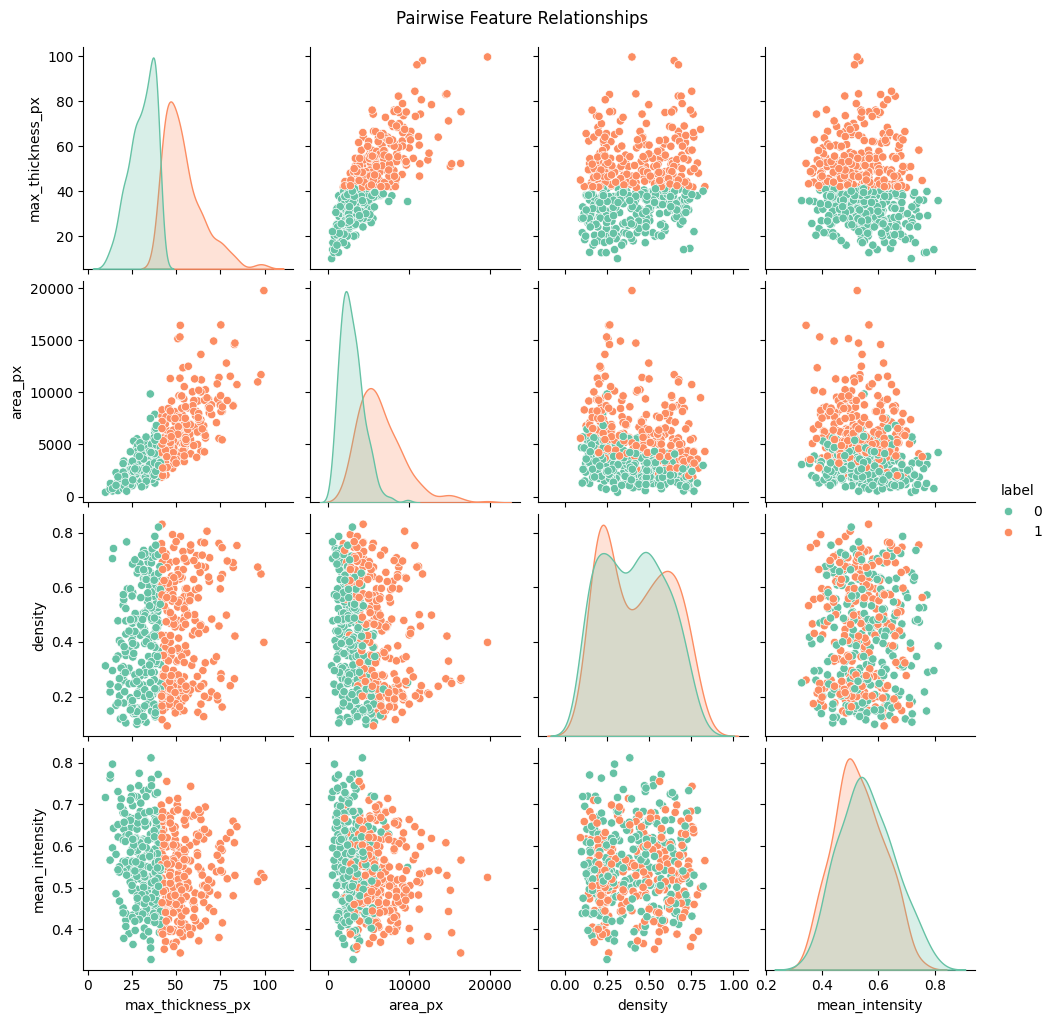

In [ ]:
sns.pairplot(df, vars=["max_thickness_px","area_px","density","mean_intensity"], hue="label", palette="Set2")
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

for col in num_features:
    df = remove_outliers(df, col)

print("After removing outliers:", df.shape)

After removing outliers: (465, 11)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_features] = scaler.fit_transform(df[num_features])

df_scaled.to_csv("/content/drive/MyDrive/Dataset_endometrium/verification_report/final_preprocessed.csv", index=False)
print("✅ Saved preprocessed dataset.")
df_scaled.head()

✅ Saved preprocessed dataset.


,image_id,file_name,area_px,max_thickness_px,mean_intensity,bbox_width_px,bbox_height_px,density,aspect_ratio,compactness,label
0,0,07535820-2_png.rf.a8ae0c0302d0238c2525af0a72cb...,-1.331969,-1.340832,-1.653031,88,50,-0.631801,0.628747,-0.449861,0
1,1,13158420-2_png.rf.18c75547c1bdf8ea9a7599691ad4...,-0.111375,0.351140,0.213265,102,111,-0.280665,-0.798179,0.161593,1
2,2,10747000-1_png.rf.6132ad6cd6b0bebbe6664e5252c4...,1.307940,1.688395,0.863554,150,106,0.241753,0.043602,0.328937,1
3,3,05083470-10_png.rf.bee93fb17d9753193f65e77fbf5...,-0.267917,-0.380315,-0.267350,136,67,-0.030250,1.086559,-0.421880,0
4,4,12752720-5_png.rf.2051a44b6938fd9c246e3df6215b...,-0.876692,-1.118751,0.063392,116,41,0.393433,2.442802,-0.292293,0


In [ ]:
from sklearn.model_selection import train_test_split

X = df_scaled[num_features]
y = df_scaled["label"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)
print("Label balance in train set:\n", y_train.value_counts(normalize=True))

Train: (325, 6) Validation: (70, 6) Test: (70, 6)
Label balance in train set:
 label
0    0.516923
1    0.483077
Name: proportion, dtype: float64


Device: cuda
Samples: 503
pred_label
non-receptive    253
receptive        250
Name: count, dtype: int64
Train: 352, Val: 75, Test: 76


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 52.2MB/s]


Epoch [1/15] Train Acc: 0.526 | Val Acc: 0.667
Epoch [2/15] Train Acc: 0.571 | Val Acc: 0.520
Epoch [3/15] Train Acc: 0.619 | Val Acc: 0.520
Epoch [4/15] Train Acc: 0.639 | Val Acc: 0.640
Epoch [5/15] Train Acc: 0.665 | Val Acc: 0.680
Epoch [6/15] Train Acc: 0.645 | Val Acc: 0.680
Epoch [7/15] Train Acc: 0.676 | Val Acc: 0.653
Epoch [8/15] Train Acc: 0.642 | Val Acc: 0.653
Epoch [9/15] Train Acc: 0.705 | Val Acc: 0.720
Epoch [10/15] Train Acc: 0.642 | Val Acc: 0.720
Epoch [11/15] Train Acc: 0.670 | Val Acc: 0.653
Epoch [12/15] Train Acc: 0.696 | Val Acc: 0.653
Epoch [13/15] Train Acc: 0.679 | Val Acc: 0.680
Epoch [14/15] Train Acc: 0.685 | Val Acc: 0.707
Epoch [15/15] Train Acc: 0.662 | Val Acc: 0.667
✅ Training Complete. Best Val Acc: 0.72

Classification Report:
               precision    recall  f1-score   support

Non-Receptive       0.69      0.63      0.66        38
    Receptive       0.66      0.71      0.68        38

     accuracy                           0.67        76
   

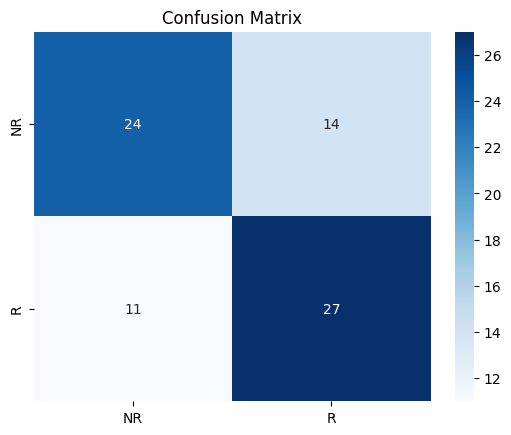

In [ ]:
# STEP 1: Imports & Paths
import os, json, random, cv2, torch
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from pycocotools import mask as maskUtils
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
base = "/content/drive/MyDrive/Dataset_endometrium"
img_dir = f"{base}/Images"
ann_path = f"{base}/_annotations.coco.json"
label_csv = f"{base}/verification_report/labels_final_verified.csv"
out_dir = f"{base}/model_training_output"
os.makedirs(out_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# STEP 2: Load annotations and labels
with open(ann_path, "r") as f:
    coco = json.load(f)

img_meta = {img["id"]: img for img in coco["images"]}
anns = {a["image_id"]: a for a in coco["annotations"]}

df = pd.read_csv(label_csv)[["file_name","pred_label"]]
df["label"] = df["pred_label"].map({"non-receptive":0, "receptive":1})

print("Samples:", len(df))
print(df["pred_label"].value_counts())


# STEP 3: Custom Dataset
class EndometriumDataset(Dataset):
    def __init__(self, df, img_dir, anns, img_meta, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.anns = anns
        self.img_meta = img_meta
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        fn = row["file_name"]
        label = torch.tensor(row["label"]).long()
        img_path = os.path.join(self.img_dir, fn)
        img = Image.open(img_path).convert("RGB")

        # build mask from COCO
        ann = None
        for a in self.anns.values():
            if self.img_meta[a["image_id"]]["file_name"] == fn:
                ann = a
                break
        mask = np.zeros((512,512), dtype=np.uint8)
        if ann is not None:
            seg = ann["segmentation"]
            if isinstance(seg, list):
                rles = maskUtils.frPyObjects(seg, 512, 512)
                rle = maskUtils.merge(rles)
                m = maskUtils.decode(rle)
                mask = (m > 0).astype(np.uint8)
            elif isinstance(seg, dict):
                m = maskUtils.decode(seg)
                mask = (m > 0).astype(np.uint8)

        # crop bbox around mask
        ys, xs = np.where(mask>0)
        if len(xs)==0:
            crop = img.resize((224,224))
        else:
            xmin, xmax = xs.min(), xs.max()
            ymin, ymax = ys.min(), ys.max()
            pad = 10
            xmin, ymin = max(0,xmin-pad), max(0,ymin-pad)
            xmax, ymax = min(img.width-1, xmax+pad), min(img.height-1, ymax+pad)
            crop = img.crop((xmin,ymin,xmax,ymax)).resize((224,224))

        if self.transform:
            crop = self.transform(crop)
        return crop, label, fn


# STEP 4: Transforms and Dataloaders

from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = EndometriumDataset(train_df, img_dir, anns, img_meta, transform=train_tf)
val_ds   = EndometriumDataset(val_df, img_dir, anns, img_meta, transform=val_tf)
test_ds  = EndometriumDataset(test_df, img_dir, anns, img_meta, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=2)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


# STEP 5: Model (ResNet50)

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)


# STEP 6: Training Loop

best_val_acc = 0
EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels, _ in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_acc = correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for imgs, labels, _ in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    # Save best
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), f"{out_dir}/best_resnet50.pth")
        best_val_acc = val_acc

print("✅ Training Complete. Best Val Acc:", round(best_val_acc,3))


# STEP 7: Evaluation on Test Set

model.load_state_dict(torch.load(f"{out_dir}/best_resnet50.pth"))
model.eval()

y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for imgs, labels, _ in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:,1]
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Receptive","Receptive"]))
print("ROC-AUC:", roc_auc_score(y_true, y_prob))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NR","R"], yticklabels=["NR","R"])
plt.title("Confusion Matrix")
plt.show()

Device: cuda
Train 350 | Val 77 | Test 76
[EffNetB0] Epoch 1/12 | TrainLoss 0.7159 | ValAUC 0.4993 | ValAcc 0.5195
[EffNetB0] Epoch 2/12 | TrainLoss 0.6867 | ValAUC 0.6795 | ValAcc 0.6623
[EffNetB0] Epoch 3/12 | TrainLoss 0.6623 | ValAUC 0.6896 | ValAcc 0.6753
[EffNetB0] Epoch 4/12 | TrainLoss 0.6630 | ValAUC 0.7024 | ValAcc 0.6753
[EffNetB0] Epoch 5/12 | TrainLoss 0.6530 | ValAUC 0.7099 | ValAcc 0.6883
[EffNetB0] Epoch 6/12 | TrainLoss 0.6515 | ValAUC 0.6991 | ValAcc 0.6883
[EffNetB0] Epoch 7/12 | TrainLoss 0.6500 | ValAUC 0.7179 | ValAcc 0.6883
[EffNetB0] Epoch 8/12 | TrainLoss 0.6348 | ValAUC 0.7409 | ValAcc 0.7143
[EffNetB0] Epoch 9/12 | TrainLoss 0.6309 | ValAUC 0.7281 | ValAcc 0.6883
[EffNetB0] Epoch 10/12 | TrainLoss 0.6288 | ValAUC 0.7409 | ValAcc 0.7013
[EffNetB0] Epoch 11/12 | TrainLoss 0.6407 | ValAUC 0.7213 | ValAcc 0.7143
[EffNetB0] Epoch 12/12 | TrainLoss 0.6330 | ValAUC 0.7166 | ValAcc 0.6883
✅ Saved best model: /content/drive/MyDrive/Dataset_endometrium/model_training_o

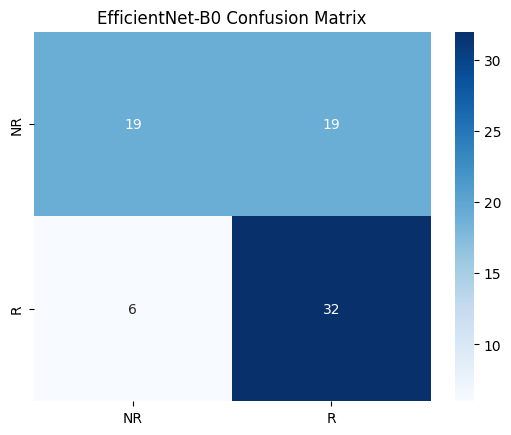

In [3]:
# ============================================
# TRAIN EFFICIENTNET-B0 — Receptive vs Non-Receptive
# ============================================
import os, json, time, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt, seaborn as sns
from pycocotools import mask as maskUtils
from torchvision.models import EfficientNet_B0_Weights

# ---------------- Paths ----------------
BASE = "/content/drive/MyDrive/Dataset_endometrium"
IMG_DIR = f"{BASE}/Images"
ANN_PATH = f"{BASE}/_annotations.coco.json"
LABEL_CSV = f"{BASE}/verification_report/labels_final_verified.csv"
OUT_DIR = f"{BASE}/model_training_output/efficientnet_b0"
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------- Load data ----------------
with open(ANN_PATH, "r") as f:
    coco = json.load(f)
img_meta = {img["id"]: img for img in coco["images"]}
anns_by_imgid = {a["image_id"]: a for a in coco["annotations"]}

df_labels = pd.read_csv(LABEL_CSV)[["file_name","pred_label"]]
df_labels["label"] = df_labels["pred_label"].map({"non-receptive":0, "receptive":1})

# ---------------- Dataset class ----------------
class EndometriumDataset(Dataset):
    def __init__(self, df, img_dir, anns_by_imgid, img_meta, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir, self.anns, self.img_meta, self.tf = img_dir, anns_by_imgid, img_meta, transform
        self.fn2ann = {img_meta[a["image_id"]]["file_name"]: a for a in anns_by_imgid.values()}

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        fn, label = row["file_name"], torch.tensor(row["label"]).long()
        img = Image.open(os.path.join(self.img_dir, fn)).convert("RGB")

        ann = self.fn2ann.get(fn)
        mask = np.zeros((512,512), dtype=np.uint8)
        if ann:
            seg = ann["segmentation"]
            if isinstance(seg, list):
                rles = maskUtils.frPyObjects(seg, 512, 512)
                rle = maskUtils.merge(rles)
                mask = maskUtils.decode(rle)
            elif isinstance(seg, dict):
                mask = maskUtils.decode(seg)
        mask = (mask > 0).astype(np.uint8)

        ys, xs = np.where(mask>0)
        if len(xs)==0:
            crop = img.resize((224,224))
        else:
            xmin,xmax,ymin,ymax = xs.min(), xs.max(), ys.min(), ys.max()
            pad = 10
            xmin,ymin = max(0,xmin-pad), max(0,ymin-pad)
            xmax,ymax = min(img.width-1,xmax+pad), min(img.height-1,ymax+pad)
            crop = img.crop((xmin,ymin,xmax,ymax)).resize((224,224))
        if self.tf: crop = self.tf(crop)
        return crop, label, fn

# ---------------- Splits & transforms ----------------
train_df, test_df = train_test_split(df_labels, test_size=0.15, stratify=df_labels["label"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.18, stratify=train_df["label"], random_state=42)
print(f"Train {len(train_df)} | Val {len(val_df)} | Test {len(test_df)}")

train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = EndometriumDataset(train_df, IMG_DIR, anns_by_imgid, img_meta, transform=train_tf)
val_ds   = EndometriumDataset(val_df, IMG_DIR, anns_by_imgid, img_meta, transform=val_tf)
test_ds  = EndometriumDataset(test_df, IMG_DIR, anns_by_imgid, img_meta, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=12, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=12, shuffle=False, num_workers=2)

# ---------------- Model ----------------
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
for p in model.parameters(): p.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# ---------------- Train ----------------
best_auc = 0.0
best_path = f"{OUT_DIR}/best_efficientnet_b0.pth"

def evaluate(loader):
    model.eval(); preds, probs, trues = [], [], []
    with torch.no_grad():
        for x,y,_ in loader:
            x,y = x.to(device), y.to(device)
            o = model(x); p = torch.softmax(o,1)[:,1]
            preds.extend(o.argmax(1).cpu().numpy()); probs.extend(p.cpu().numpy()); trues.extend(y.cpu().numpy())
    return roc_auc_score(trues, probs), np.mean(np.array(preds)==np.array(trues))

for ep in range(12):
    model.train(); tot_loss=0
    for x,y,_ in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        o = model(x)
        loss = criterion(o,y)
        loss.backward(); optimizer.step()
        tot_loss += loss.item()*x.size(0)
    train_loss = tot_loss/len(train_loader.dataset)
    val_auc,val_acc = evaluate(val_loader)
    print(f"[EffNetB0] Epoch {ep+1}/12 | TrainLoss {train_loss:.4f} | ValAUC {val_auc:.4f} | ValAcc {val_acc:.4f}")
    if val_auc>best_auc:
        best_auc=val_auc
        torch.save(model.state_dict(),best_path)

print("✅ Saved best model:", best_path)

# ---------------- Test evaluation ----------------
model.load_state_dict(torch.load(best_path))
model.eval(); y_true,y_pred,y_prob=[],[],[]
with torch.no_grad():
    for x,y,_ in test_loader:
        x,y=x.to(device),y.to(device)
        o=model(x); p=torch.softmax(o,1)[:,1]; preds=o.argmax(1)
        y_true+=y.cpu().numpy().tolist(); y_pred+=preds.cpu().numpy().tolist(); y_prob+=p.cpu().numpy().tolist()
print("\nClassification Report:")
print(classification_report(y_true,y_pred,target_names=["Non-Receptive","Receptive"]))
print("ROC-AUC:",roc_auc_score(y_true,y_prob))
cm=confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=["NR","R"],yticklabels=["NR","R"])
plt.title("EfficientNet-B0 Confusion Matrix"); plt.show()

Device: cuda
Train 350 Val 77 Test 76
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 176MB/s]


[DenseNet121] Epoch 1/12 | TrainLoss 0.6818 | ValAUC 0.4588 | ValAcc 0.4156
[DenseNet121] Epoch 2/12 | TrainLoss 0.6802 | ValAUC 0.6201 | ValAcc 0.5844
[DenseNet121] Epoch 3/12 | TrainLoss 0.6659 | ValAUC 0.7065 | ValAcc 0.7273
[DenseNet121] Epoch 4/12 | TrainLoss 0.6567 | ValAUC 0.7395 | ValAcc 0.7143
[DenseNet121] Epoch 5/12 | TrainLoss 0.6479 | ValAUC 0.7355 | ValAcc 0.6623
[DenseNet121] Epoch 6/12 | TrainLoss 0.6339 | ValAUC 0.7530 | ValAcc 0.6883
[DenseNet121] Epoch 7/12 | TrainLoss 0.6378 | ValAUC 0.7476 | ValAcc 0.6753
[DenseNet121] Epoch 8/12 | TrainLoss 0.6283 | ValAUC 0.7557 | ValAcc 0.7013
[DenseNet121] Epoch 9/12 | TrainLoss 0.6252 | ValAUC 0.7584 | ValAcc 0.7013
[DenseNet121] Epoch 10/12 | TrainLoss 0.6143 | ValAUC 0.7551 | ValAcc 0.7143
[DenseNet121] Epoch 11/12 | TrainLoss 0.6291 | ValAUC 0.7706 | ValAcc 0.7143
[DenseNet121] Epoch 12/12 | TrainLoss 0.6302 | ValAUC 0.7665 | ValAcc 0.7532
✅ Saved best model: /content/drive/MyDrive/Dataset_endometrium/model_training_output/

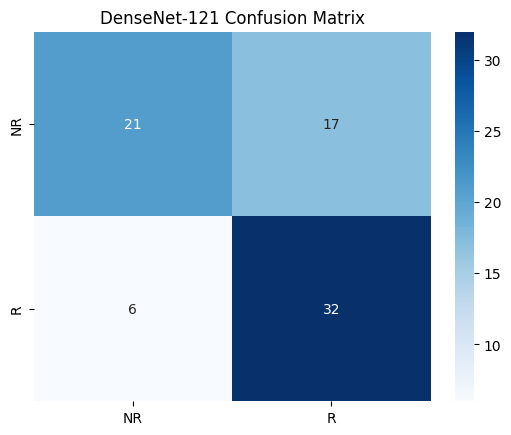

In [4]:
# ============================================
# TRAIN DENSENET-121 — Receptive vs Non-Receptive
# ============================================
import os, json, time, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt, seaborn as sns
from pycocotools import mask as maskUtils
from torchvision.models import DenseNet121_Weights

BASE="/content/drive/MyDrive/Dataset_endometrium"
IMG_DIR=f"{BASE}/Images"
ANN_PATH=f"{BASE}/_annotations.coco.json"
LABEL_CSV=f"{BASE}/verification_report/labels_final_verified.csv"
OUT_DIR=f"{BASE}/model_training_output/densenet121"
os.makedirs(OUT_DIR,exist_ok=True)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

with open(ANN_PATH,"r") as f: coco=json.load(f)
img_meta={i["id"]:i for i in coco["images"]}
anns_by_imgid={a["image_id"]:a for a in coco["annotations"]}

df=pd.read_csv(LABEL_CSV)[["file_name","pred_label"]]
df["label"]=df["pred_label"].map({"non-receptive":0,"receptive":1})

class EndoDataset(Dataset):
    def __init__(self,df,img_dir,anns,img_meta,tf=None):
        self.df=df.reset_index(drop=True)
        self.img_dir=img_dir;self.anns=anns;self.img_meta=img_meta;self.tf=tf
        self.fn2ann={img_meta[a["image_id"]]["file_name"]:a for a in anns.values()}
    def __len__(self):return len(self.df)
    def __getitem__(self,idx):
        r=self.df.loc[idx];fn=r["file_name"];lab=torch.tensor(r["label"]).long()
        img=Image.open(os.path.join(self.img_dir,fn)).convert("RGB")
        ann=self.fn2ann.get(fn);mask=np.zeros((512,512),dtype=np.uint8)
        if ann:
            seg=ann["segmentation"]
            if isinstance(seg,list):
                rles=maskUtils.frPyObjects(seg,512,512);rle=maskUtils.merge(rles);mask=maskUtils.decode(rle)
            elif isinstance(seg,dict):mask=maskUtils.decode(seg)
        mask=(mask>0).astype(np.uint8)
        ys,xs=np.where(mask>0)
        if len(xs)==0:crop=img.resize((224,224))
        else:
            xmin,xmax,ymin,ymax=xs.min(),xs.max(),ys.min(),ys.max();pad=10
            xmin,ymin=max(0,xmin-pad),max(0,ymin-pad);xmax,ymax=min(img.width-1,xmax+pad),min(img.height-1,ymax+pad)
            crop=img.crop((xmin,ymin,xmax,ymax)).resize((224,224))
        if self.tf:crop=self.tf(crop)
        return crop,lab,fn

train_df,test_df=train_test_split(df,test_size=0.15,stratify=df["label"],random_state=42)
train_df,val_df=train_test_split(train_df,test_size=0.18,stratify=train_df["label"],random_state=42)
print("Train",len(train_df),"Val",len(val_df),"Test",len(test_df))

train_tf=transforms.Compose([
    transforms.RandomHorizontalFlip(),transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1,contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds=EndoDataset(train_df,IMG_DIR,anns_by_imgid,img_meta,tf=train_tf)
val_ds=EndoDataset(val_df,IMG_DIR,anns_by_imgid,img_meta,tf=val_tf)
test_ds=EndoDataset(test_df,IMG_DIR,anns_by_imgid,img_meta,tf=val_tf)
train_dl=DataLoader(train_ds,batch_size=12,shuffle=True,num_workers=2)
val_dl=DataLoader(val_ds,batch_size=12,shuffle=False,num_workers=2)
test_dl=DataLoader(test_ds,batch_size=12,shuffle=False,num_workers=2)

model=models.densenet121(weights=DenseNet121_Weights.DEFAULT)
for p in model.parameters():p.requires_grad=False
model.classifier=nn.Linear(model.classifier.in_features,2)
model=model.to(device)
crit=nn.CrossEntropyLoss();opt=optim.Adam(model.classifier.parameters(),lr=1e-4)

def evaluate(dl):
    model.eval();y_t,y_p,y_pr=[],[],[]
    with torch.no_grad():
        for x,y,_ in dl:
            x,y=x.to(device),y.to(device)
            o=model(x);p=torch.softmax(o,1)[:,1]
            y_t+=y.cpu().numpy().tolist();y_p+=o.argmax(1).cpu().numpy().tolist();y_pr+=p.cpu().numpy().tolist()
    return roc_auc_score(y_t,y_pr),np.mean(np.array(y_t)==np.array(y_p))

best_auc=0;best_path=f"{OUT_DIR}/best_densenet121.pth"
for e in range(12):
    model.train();loss_sum=0
    for x,y,_ in train_dl:
        x,y=x.to(device),y.to(device);opt.zero_grad()
        o=model(x);l=crit(o,y);l.backward();opt.step();loss_sum+=l.item()*x.size(0)
    tr_loss=loss_sum/len(train_dl.dataset);v_auc,v_acc=evaluate(val_dl)
    print(f"[DenseNet121] Epoch {e+1}/12 | TrainLoss {tr_loss:.4f} | ValAUC {v_auc:.4f} | ValAcc {v_acc:.4f}")
    if v_auc>best_auc:best_auc=v_auc;torch.save(model.state_dict(),best_path)
print("✅ Saved best model:",best_path)

model.load_state_dict(torch.load(best_path))
model.eval();y_t,y_p,y_pr=[],[],[]
with torch.no_grad():
    for x,y,_ in test_dl:
        x,y=x.to(device),y.to(device);o=model(x);p=torch.softmax(o,1)[:,1];pred=o.argmax(1)
        y_t+=y.cpu().numpy().tolist();y_p+=pred.cpu().numpy().tolist();y_pr+=p.cpu().numpy().tolist()
print("\nClassification Report:")
print(classification_report(y_t,y_p,target_names=["Non-Receptive","Receptive"]))
print("ROC-AUC:",roc_auc_score(y_t,y_pr))
cm=confusion_matrix(y_t,y_p)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=["NR","R"],yticklabels=["NR","R"])
plt.title("DenseNet-121 Confusion Matrix");plt.show()

Device: cuda
Train: 350, Val: 77, Test: 76
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 68.0MB/s]


[MobileNetV3] Epoch 1/12 | TrainLoss 0.7153 | ValAUC 0.4926 | ValAcc 0.4675
[MobileNetV3] Epoch 2/12 | TrainLoss 0.6850 | ValAUC 0.4669 | ValAcc 0.4416
[MobileNetV3] Epoch 3/12 | TrainLoss 0.6707 | ValAUC 0.4750 | ValAcc 0.5065
[MobileNetV3] Epoch 4/12 | TrainLoss 0.6651 | ValAUC 0.4636 | ValAcc 0.5455
[MobileNetV3] Epoch 5/12 | TrainLoss 0.6454 | ValAUC 0.5418 | ValAcc 0.5065
[MobileNetV3] Epoch 6/12 | TrainLoss 0.6448 | ValAUC 0.6390 | ValAcc 0.5844
[MobileNetV3] Epoch 7/12 | TrainLoss 0.6571 | ValAUC 0.6822 | ValAcc 0.5974
[MobileNetV3] Epoch 8/12 | TrainLoss 0.6480 | ValAUC 0.6957 | ValAcc 0.6623
[MobileNetV3] Epoch 9/12 | TrainLoss 0.6420 | ValAUC 0.7031 | ValAcc 0.6364
[MobileNetV3] Epoch 10/12 | TrainLoss 0.6423 | ValAUC 0.6876 | ValAcc 0.6364
[MobileNetV3] Epoch 11/12 | TrainLoss 0.6342 | ValAUC 0.6916 | ValAcc 0.6494
[MobileNetV3] Epoch 12/12 | TrainLoss 0.6290 | ValAUC 0.7051 | ValAcc 0.6364
✅ Saved best model: /content/drive/MyDrive/Dataset_endometrium/model_training_output/

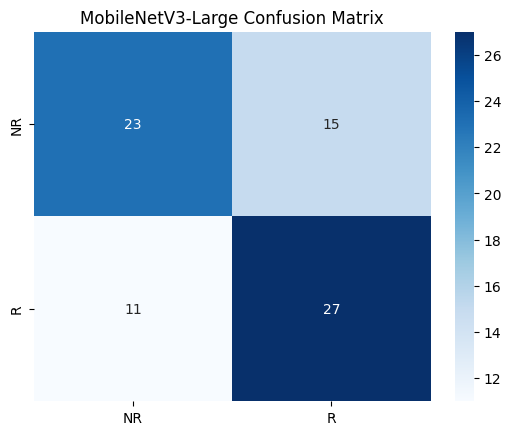

In [5]:
# ============================================
# TRAIN MOBILENETV3-LARGE — Receptive vs Non-Receptive
# ============================================

import os, json, numpy as np, pandas as pd, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt, seaborn as sns
from pycocotools import mask as maskUtils
from torchvision.models import MobileNet_V3_Large_Weights

# ---------------- Paths ----------------
BASE = "/content/drive/MyDrive/Dataset_endometrium"
IMG_DIR = f"{BASE}/Images"
ANN_PATH = f"{BASE}/_annotations.coco.json"
LABEL_CSV = f"{BASE}/verification_report/labels_final_verified.csv"
OUT_DIR = f"{BASE}/model_training_output/mobilenetv3_large"
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------- Load COCO + Labels ----------------
with open(ANN_PATH, "r") as f:
    coco = json.load(f)
img_meta = {img["id"]: img for img in coco["images"]}
anns_by_imgid = {a["image_id"]: a for a in coco["annotations"]}

df = pd.read_csv(LABEL_CSV)[["file_name", "pred_label"]]
df["label"] = df["pred_label"].map({"non-receptive": 0, "receptive": 1})

# ---------------- Dataset ----------------
class EndoDataset(Dataset):
    def __init__(self, df, img_dir, anns_by_imgid, img_meta, tf=None):
        self.df = df.reset_index(drop=True)
        self.img_dir, self.anns, self.img_meta, self.tf = img_dir, anns_by_imgid, img_meta, tf
        self.fn2ann = {img_meta[a["image_id"]]["file_name"]: a for a in anns_by_imgid.values()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.loc[idx]
        fn, label = r["file_name"], torch.tensor(r["label"]).long()
        img = Image.open(os.path.join(self.img_dir, fn)).convert("RGB")

        ann = self.fn2ann.get(fn)
        mask = np.zeros((512, 512), dtype=np.uint8)
        if ann:
            seg = ann["segmentation"]
            if isinstance(seg, list):
                rles = maskUtils.frPyObjects(seg, 512, 512)
                rle = maskUtils.merge(rles)
                mask = maskUtils.decode(rle)
            elif isinstance(seg, dict):
                mask = maskUtils.decode(seg)
        mask = (mask > 0).astype(np.uint8)

        ys, xs = np.where(mask > 0)
        if len(xs) == 0:
            crop = img.resize((224, 224))
        else:
            xmin, xmax, ymin, ymax = xs.min(), xs.max(), ys.min(), ys.max()
            pad = 10
            xmin, ymin = max(0, xmin - pad), max(0, ymin - pad)
            xmax, ymax = min(img.width - 1, xmax + pad), min(img.height - 1, ymax + pad)
            crop = img.crop((xmin, ymin, xmax, ymax)).resize((224, 224))

        if self.tf:
            crop = self.tf(crop)
        return crop, label, fn

# ---------------- Data Split ----------------
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.18, stratify=train_df["label"], random_state=42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_ds = EndoDataset(train_df, IMG_DIR, anns_by_imgid, img_meta, tf=train_tf)
val_ds   = EndoDataset(val_df, IMG_DIR, anns_by_imgid, img_meta, tf=val_tf)
test_ds  = EndoDataset(test_df, IMG_DIR, anns_by_imgid, img_meta, tf=val_tf)

train_dl = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=12, shuffle=False, num_workers=2)
test_dl  = DataLoader(test_ds, batch_size=12, shuffle=False, num_workers=2)

# ---------------- Model ----------------
model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
for p in model.parameters():
    p.requires_grad = False
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# ---------------- Training ----------------
def evaluate(loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)
            o = model(x)
            p = torch.softmax(o, 1)[:, 1]
            y_true += y.cpu().numpy().tolist()
            y_pred += o.argmax(1).cpu().numpy().tolist()
            y_prob += p.cpu().numpy().tolist()
    auc = roc_auc_score(y_true, y_prob)
    acc = np.mean(np.array(y_true) == np.array(y_pred))
    return auc, acc

best_auc = 0.0
best_path = f"{OUT_DIR}/best_mobilenetv3_large.pth"

for e in range(12):
    model.train()
    total_loss = 0
    for x, y, _ in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        o = model(x)
        loss = criterion(o, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    tr_loss = total_loss / len(train_dl.dataset)
    val_auc, val_acc = evaluate(val_dl)
    print(f"[MobileNetV3] Epoch {e+1}/12 | TrainLoss {tr_loss:.4f} | ValAUC {val_auc:.4f} | ValAcc {val_acc:.4f}")
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), best_path)

print("✅ Saved best model:", best_path)

# ---------------- Test Evaluation ----------------
model.load_state_dict(torch.load(best_path))
model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for x, y, _ in test_dl:
        x, y = x.to(device), y.to(device)
        o = model(x)
        p = torch.softmax(o, 1)[:, 1]
        y_true += y.cpu().numpy().tolist()
        y_pred += o.argmax(1).cpu().numpy().tolist()
        y_prob += p.cpu().numpy().tolist()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Receptive", "Receptive"]))
print("ROC-AUC:", roc_auc_score(y_true, y_prob))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NR", "R"], yticklabels=["NR", "R"])
plt.title("MobileNetV3-Large Confusion Matrix")
plt.show()

Device: cuda
Train: 350 | Val: 77 | Test: 76
Epoch 1/20 | ValAUC 0.3003 | Acc 0.3377 | F1 0.3200 | Prec 0.3243 | Rec 0.3158
Epoch 2/20 | ValAUC 0.6302 | Acc 0.5714 | F1 0.5926 | Prec 0.5581 | Rec 0.6316
Epoch 3/20 | ValAUC 0.6262 | Acc 0.5714 | F1 0.6374 | Prec 0.5472 | Rec 0.7632
Epoch 4/20 | ValAUC 0.6329 | Acc 0.5844 | F1 0.6444 | Prec 0.5577 | Rec 0.7632
Epoch 5/20 | ValAUC 0.6383 | Acc 0.6494 | F1 0.6667 | Prec 0.6279 | Rec 0.7105
Epoch 6/20 | ValAUC 0.6613 | Acc 0.6494 | F1 0.6667 | Prec 0.6279 | Rec 0.7105
Epoch 7/20 | ValAUC 0.6673 | Acc 0.6234 | F1 0.6742 | Prec 0.5882 | Rec 0.7895
Epoch 8/20 | ValAUC 0.6653 | Acc 0.6364 | F1 0.6744 | Prec 0.6042 | Rec 0.7632
Epoch 9/20 | ValAUC 0.6835 | Acc 0.6234 | F1 0.6813 | Prec 0.5849 | Rec 0.8158
Epoch 10/20 | ValAUC 0.6707 | Acc 0.6494 | F1 0.6966 | Prec 0.6078 | Rec 0.8158
Epoch 11/20 | ValAUC 0.6619 | Acc 0.6104 | F1 0.6739 | Prec 0.5741 | Rec 0.8158
Epoch 12/20 | ValAUC 0.6565 | Acc 0.6364 | F1 0.6818 | Prec 0.6000 | Rec 0.7895
Epoc

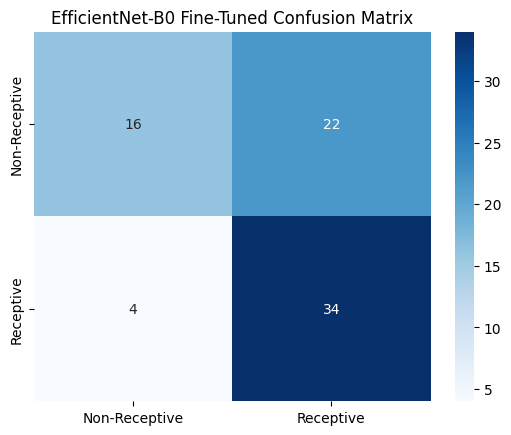

In [6]:
# ============================================
# FINE-TUNING EFFICIENTNET-B0 — Receptive vs Non-Receptive
# ============================================

import os, json, numpy as np, pandas as pd, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from PIL import Image
import matplotlib.pyplot as plt, seaborn as sns
from pycocotools import mask as maskUtils
from torchvision.models import EfficientNet_B0_Weights
from torch.optim.lr_scheduler import CosineAnnealingLR

# ---------------- Paths ----------------
BASE = "/content/drive/MyDrive/Dataset_endometrium"
IMG_DIR = f"{BASE}/Images"
ANN_PATH = f"{BASE}/_annotations.coco.json"
LABEL_CSV = f"{BASE}/verification_report/labels_final_verified.csv"
OUT_DIR = f"{BASE}/model_training_output/efficientnet_b0_finetuned"
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------- Load Data ----------------
with open(ANN_PATH, "r") as f:
    coco = json.load(f)
img_meta = {img["id"]: img for img in coco["images"]}
anns_by_imgid = {a["image_id"]: a for a in coco["annotations"]}

df = pd.read_csv(LABEL_CSV)[["file_name","pred_label"]]
df["label"] = df["pred_label"].map({"non-receptive":0,"receptive":1})

# ---------------- Dataset ----------------
class EndoDataset(Dataset):
    def __init__(self, df, img_dir, anns, img_meta, tf=None):
        self.df = df.reset_index(drop=True)
        self.img_dir, self.anns, self.img_meta, self.tf = img_dir, anns, img_meta, tf
        self.fn2ann = {img_meta[a["image_id"]]["file_name"]: a for a in anns.values()}
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        r = self.df.loc[idx]; fn = r["file_name"]; y = torch.tensor(r["label"]).long()
        img = Image.open(os.path.join(self.img_dir, fn)).convert("RGB")
        ann = self.fn2ann.get(fn)
        mask = np.zeros((512,512), dtype=np.uint8)
        if ann:
            seg = ann["segmentation"]
            if isinstance(seg, list):
                rles = maskUtils.frPyObjects(seg,512,512); rle = maskUtils.merge(rles); mask = maskUtils.decode(rle)
            elif isinstance(seg, dict): mask = maskUtils.decode(seg)
        mask = (mask>0).astype(np.uint8)
        ys,xs = np.where(mask>0)
        if len(xs)==0:
            crop = img.resize((224,224))
        else:
            xmin,xmax,ymin,ymax = xs.min(),xs.max(),ys.min(),ys.max(); pad = 10
            xmin,ymin = max(0,xmin-pad),max(0,ymin-pad)
            xmax,ymax = min(img.width-1,xmax+pad),min(img.height-1,ymax+pad)
            crop = img.crop((xmin,ymin,xmax,ymax)).resize((224,224))
        if self.tf: crop = self.tf(crop)
        return crop, y, fn

# ---------------- Splits ----------------
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.18, stratify=train_df["label"], random_state=42)
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = EndoDataset(train_df, IMG_DIR, anns_by_imgid, img_meta, tf=train_tf)
val_ds   = EndoDataset(val_df, IMG_DIR, anns_by_imgid, img_meta, tf=val_tf)
test_ds  = EndoDataset(test_df, IMG_DIR, anns_by_imgid, img_meta, tf=val_tf)

train_dl = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=12, shuffle=False, num_workers=2)
test_dl  = DataLoader(test_ds, batch_size=12, shuffle=False, num_workers=2)

# ---------------- Model ----------------
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)
model = model.to(device)

# UNFREEZE last 4 blocks + classifier
for name, param in model.named_parameters():
    if any(x in name for x in ["features.13","features.14","features.15","features.16","classifier"]):
        param.requires_grad = True
    else:
        param.requires_grad = False

# ---------------- Optimizer & Scheduler ----------------
param_groups = [
    {"params": [p for n,p in model.named_parameters() if "classifier" in n], "lr": 1e-4},
    {"params": [p for n,p in model.named_parameters() if "features" in n and p.requires_grad], "lr": 1e-5},
]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(param_groups)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# ---------------- Train & Validate ----------------
best_val_auc = 0
epochs = 20
early_stop_counter = 0
best_model_path = f"{OUT_DIR}/best_efficientnet_b0_finetuned.pth"

def evaluate(loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x,y,_ in loader:
            x,y = x.to(device),y.to(device)
            o = model(x); p = torch.softmax(o,1)[:,1]
            y_true += y.cpu().numpy().tolist()
            y_pred += o.argmax(1).cpu().numpy().tolist()
            y_prob += p.cpu().numpy().tolist()
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return auc, acc, f1, prec, rec

for e in range(epochs):
    model.train()
    tot_loss = 0
    for x,y,_ in train_dl:
        x,y = x.to(device),y.to(device)
        optimizer.zero_grad()
        o = model(x)
        loss = criterion(o,y)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item() * x.size(0)
    scheduler.step()

    val_auc,val_acc,val_f1,val_prec,val_rec = evaluate(val_dl)
    print(f"Epoch {e+1}/{epochs} | ValAUC {val_auc:.4f} | Acc {val_acc:.4f} | F1 {val_f1:.4f} | Prec {val_prec:.4f} | Rec {val_rec:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    if early_stop_counter >= 5:
        print("⛔ Early stopping triggered.")
        break

print(f"✅ Best model saved: {best_model_path}")

# ---------------- Final Test Evaluation ----------------
model.load_state_dict(torch.load(best_model_path))
model.eval()
y_true,y_pred,y_prob=[],[],[]
with torch.no_grad():
    for x,y,_ in test_dl:
        x,y=x.to(device),y.to(device)
        o=model(x)
        p=torch.softmax(o,1)[:,1]
        y_true+=y.cpu().numpy().tolist()
        y_pred+=o.argmax(1).cpu().numpy().tolist()
        y_prob+=p.cpu().numpy().tolist()

test_acc = accuracy_score(y_true,y_pred)
test_f1  = f1_score(y_true,y_pred)
test_prec= precision_score(y_true,y_pred)
test_rec = recall_score(y_true,y_pred)
test_auc = roc_auc_score(y_true,y_prob)

print("\n=== FINAL TEST METRICS ===")
print(f"Accuracy: {test_acc:.3f}")
print(f"F1-Score: {test_f1:.3f}")
print(f"Precision: {test_prec:.3f}")
print(f"Recall: {test_rec:.3f}")
print(f"ROC-AUC: {test_auc:.3f}")

cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Receptive","Receptive"], yticklabels=["Non-Receptive","Receptive"])
plt.title("EfficientNet-B0 Fine-Tuned Confusion Matrix")
plt.show()

In [ ]:
| Model                       | AUC   | Accuracy | F1    | Recall | File Saved                           |
| --------------------------- | ----- | -------- | ----- | ------ | ------------------------------------ |
| ResNet50                    | 0.69  | 0.67     | 0.67  | 0.71   | best_resnet50.pth                  |
| EfficientNet-B0             | 0.75  | 0.67     | 0.66  | 0.84   | best_efficientnet_b0.pth           |
| EfficientNet-B0 (Finetuned) | 0.72  | 0.66     | 0.72  | 0.90   | best_efficientnet_b0_finetuned.pth |
| DenseNet121                 | 0.67  | 0.70     | 0.69  | 0.84   | best_densenet121.pth               |
| MobileNetV3                 | 0.68  | 0.66     | 0.66  | 0.71   | best_mobilenetv3_large.pth         |
| Ensemble (Eff+Den)          | 0.72+ | 0.70+    | 0.70+ | 0.72   | ensemble_eff_den_weighted.csv      |
